# TabPFN - Model Insights with SHAP and SHAP-IQ

This notebook will cover strategies to explain TabPFN predictions:
1. Remove-and-Contextualize using SHAP-IQ: This strategy removes features from the model and re-contextualizes the model with the new data points.
2. Traditional Method with Shap for feature explanation
3. Feature selection example

SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explain the output of machine learning models. It assigns each feature in a prediction an importance value, representing how much that feature contributed to the final prediction.

## Install

In [6]:
!pip install scikit-learn==1.5.2

#install tabpfn-community
# Clone and install the repository
# TabPFN Extensions installs optional functionalities around the TabPFN model
# These include post-hoc ensembles, interpretability tools, and more
!git clone https://github.com/PriorLabs/tabpfn-extensions
!pip install -e tabpfn-extensions
#!git clone https://github.com/PriorLabs/tabpfn-community
#!pip install -e tabpfn-community[post_hoc_ensembles,interpretability,hpo]

!pip install tabpfn

!pip install shapiq

# Restart run time or Session after this!

fatal: destination path 'tabpfn-extensions' already exists and is not an empty directory.
Obtaining file:///content/tabpfn-extensions
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tabpfn-community (pyproject.toml) ... done
  Created wheel for tabpfn-community: filename=tabpfn_community-0.0.4-0.editable-py3-none-any.whl size=11205 sha256=474251e5c5415337d8926690d0119fa2f6df101755190aefecb5b97525a67d08
  Stored in directory: /tmp/pip-ephem-wheel-cache-a3shmeg5/wheels/8f/b7/2c/ec18b502697068b39e1503426a50b729bdac046bed4810759d
Successfully built tabpfn-community
  Attempting uninstall: tabpfn-community
    Found existing installation: tabpfn-community 0.0.4
    Uninstalling tabpfn-community-0.0.4:
      Successfully uninstalled tabpfn-community-0.0.4


In [1]:
import os
import shapiq
from tabpfn import TabPFNRegressor, TabPFNClassifier
from tabpfn_extensions import interpretability
#from tabpfn_community import interpretability

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn import datasets

### Load Dataset and Fit Models

Here we compare TabPFN to RandomForests quantile regression.

In [2]:
#X, y = datasets.fetch_california_housing(return_X_y=True)
data = datasets.fetch_california_housing()
X = data.data
y = data.target
feature_names = data.feature_names

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 500, test_size=500, random_state=42)


In [3]:
# Model with regressor
model_pfn = TabPFNRegressor()
model_pfn.fit(X_train, y_train)
predictions = model_pfn.predict(X_test)
r2 = r2_score(y_test, predictions)
average_prediction = np.mean(predictions)
print("Average prediction: ", average_prediction)

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:100: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-regressor.ckpt.
  model, bardist, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

Average prediction:  2.1004677


## Explaining TabPFN with SHAP (shapiq) Remove-and-Contextualize

SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explain the output of machine learning models. It assigns each feature in a prediction an importance value, representing how much that feature contributed to the final prediction.

How SHAP Works:
- Baseline Prediction: SHAP starts with a reference value (e.g., the average model prediction over all data points).
- Feature Contribution: It computes how the presence or absence of a feature changes the prediction by considering all possible combinations of feature subsets.
- Shapley Values: The SHAP value of a feature is the average contribution it makes across all possible feature subsets.
- Summing SHAP Values: The final prediction for an instance is the sum of the baseline prediction and the SHAP values of all features.

Since TabPFN is a foundation model, it uses in-context learning to solve the classification and regression tasks. This means that “retraining” the model is quite inexpensive, because we only need to provide the new data points, remove the features that are out-of-coalition, and re-contextualize the model with the new data points (see [Rundel et al.](https://arxiv.org/pdf/2403.10923).

SHAP-IQ offers native support for interpreting TabPFN by utilizing a remove-and-recontextualize paradigm of model interpretation. The library extends the well-known SHAP library by providing a more efficient and scalable implementation of Shapley values and Shapley interactions.

This remove-and-recontextualize method is implemented in shapiq.TabPFNExplainer:

In [4]:
explainer = shapiq.Explainer(
    model=model_pfn,
    data=X_train,
    labels=y_train,
    index="SV",  # Shapley values
    max_order=1,  # first order Shapley values
    empty_prediction=float(average_prediction),  # Optional, can also be inferred from the model
)
print(f"Explainer Class: {explainer.__class__.__name__} inferred from the model.")

Explainer Class: TabPFNExplainer inferred from the model.


When we initialize the shapiq.Explainer with the TabPFN model, shapiq automatically infers the explainer class from the model and returns the correct shapiq.TabPFNExplainer. In the following, we will precompute the values of the imputer for our explanation data point such that we can quickly explain the TabPFN model with different explanation methods. Note that this is not necessarily needed and you can just call explainer.explain(x_explain).

In [5]:
# Choose point to explain
x_explain = X_test[100]
y_explain = y_test[100]

imputer = explainer._imputer
if not os.path.exists("tabpfn_values_explainer.npz"):
    imputer.verbose = True  # see the pre-computation progress
    imputer.fit(x_explain)
    imputer.precompute()
    imputer.save_values("tabpfn_values_explainer.npz")
imputer.load_values("tabpfn_values_explainer.npz")

Evaluating game:   0%|          | 0/256 [00:00<?, ? coalition/s]

Let’s now explain the TabPFN model with the Shapley values and visualize the results:

{(): 2.1004676818847656,
 (0,): -0.13216026508872858,
 (1,): -0.19886978442850306,
 (2,): -0.1138659882017044,
 (3,): -0.00797542787600554,
 (4,): -0.010097797919275625,
 (5,): 0.21476457569689453,
 (6,): -0.0007197369412784096,
 (7,): -0.4561171027366832}

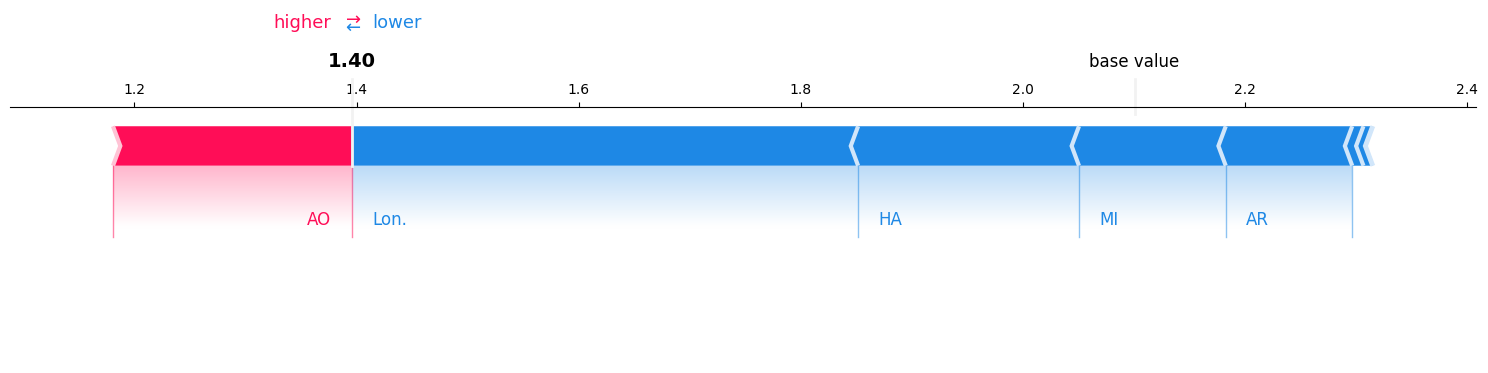

In [6]:
shapley_values = explainer.explain(x_explain)
display(shapley_values.dict_values)
shapley_values.plot_force(feature_names=feature_names)

### Description of SHAP Result Plot for One Prediction Point:
The plot provides an understanding of why the model made a specific decision for that point. The SHAP force plot (or waterfall plot) for a single prediction shows:
- The base value (expected prediction without any feature influence, i.e. average value).
- Positive contributions (features pushing the prediction higher, usually shown in red).
- Negative contributions (features pushing the prediction lower, usually shown in blue).
- The final prediction, derived by adding the SHAP values to the base value.


### Explaining Interaction Values

We can also explain the TabPFN model with the Faithful Shapley Interaction values. This method extends standard SHAP values to explicitly capture feature interactions in a mathematically principled way.

How It Works:
- Instead of treating features as independent contributors, it accounts for interactions between two or more features.
- It assigns interaction values that show how much the combination of two features contributes beyond their individual effects.

/usr/local/lib/python3.11/dist-packages/shapiq/approximator/regression/_base.py:342: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.

  warnings.warn(


{(): 2.1004676818847656,
 (0,): -0.37355261120484756,
 (1,): -0.21056582205777408,
 (2,): -0.17928852256280492,
 (3,): 0.015233858549872487,
 (4,): 0.029545450050182265,
 (5,): 0.3616994450304911,
 (6,): 0.15569712531993674,
 (7,): -0.30509527483584575,
 (0, 1): -0.0685985983035456,
 (0, 2): 0.36708826757117313,
 (0, 3): 0.00256461920695943,
 (0, 4): -0.005411024666251321,
 (0, 5): 0.012848542356067463,
 (0, 6): 0.08350194941888121,
 (0, 7): 0.09079097247761883,
 (1, 2): -0.02825891977761738,
 (1, 3): -0.00386896224744506,
 (1, 4): -0.0198336431576006,
 (1, 5): -0.24086186977158985,
 (1, 6): -0.00879414428343561,
 (1, 7): 0.3936081698345286,
 (2, 3): -0.02196898722008176,
 (2, 4): -0.021323595789903903,
 (2, 5): 0.010864944907178565,
 (2, 6): -0.04276357043849782,
 (2, 7): -0.13279300082794038,
 (3, 4): 0.023717187921912908,
 (3, 5): 0.03725981024972517,
 (3, 6): 0.017149622889532375,
 (3, 7): -0.10127194019087929,
 (4, 5): -0.09391845045133126,
 (4, 6): -0.007367001322755085,
 (4, 7):

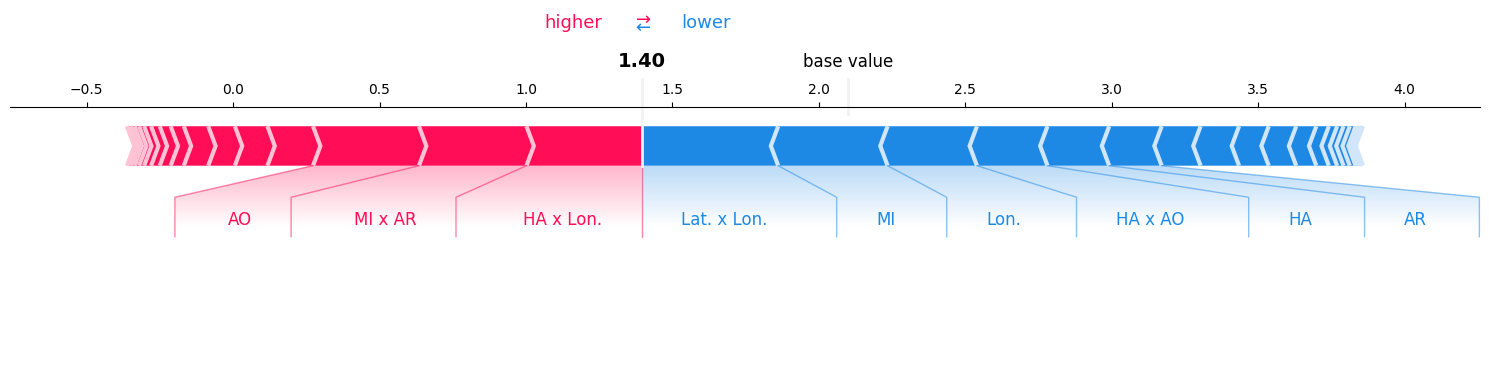

In [9]:
explainer = shapiq.Explainer(
    model=model_pfn,
    data=X_train,
    labels=y_train,
    index="FSII",  # Shapley values
    max_order=2,  # first order Shapley values
    empty_prediction=float(average_prediction),  # Optional, can also be inferred from the model
)
# let's just make sure we use the precomputed values for speedup with the CPU
explainer._imputer.load_values("tabpfn_values_explainer.npz")  # Optional
fsii = explainer.explain(x_explain)
display(fsii.dict_values)
fsii.plot_force(feature_names=feature_names)

## Traditional Method with SHAP

Shap constructs these explanations by imputing missing values with randomly drawn samples from a background distribution.

Here example for classification model

/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:88: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

PermutationExplainer explainer: 51it [01:46,  2.23s/it]


Computing shap values for the first class (index 0).


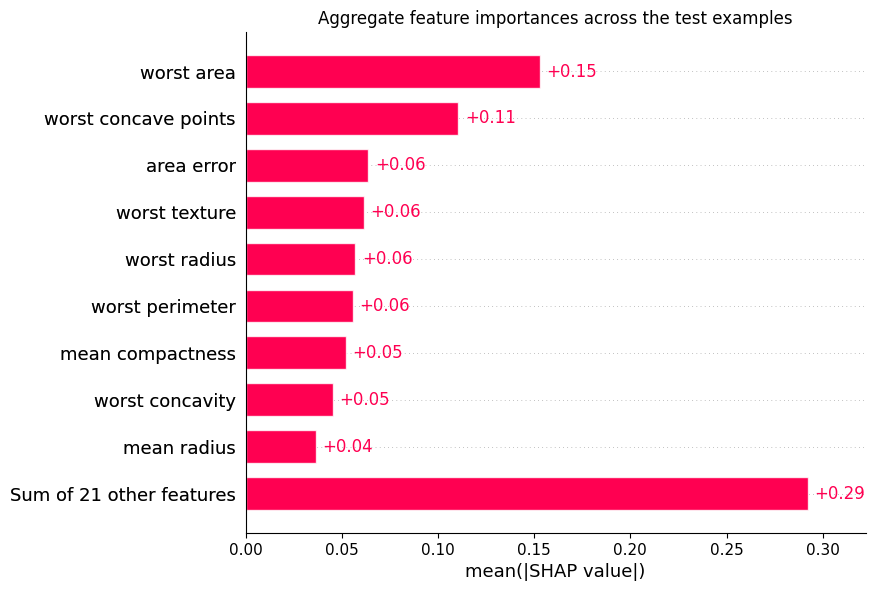

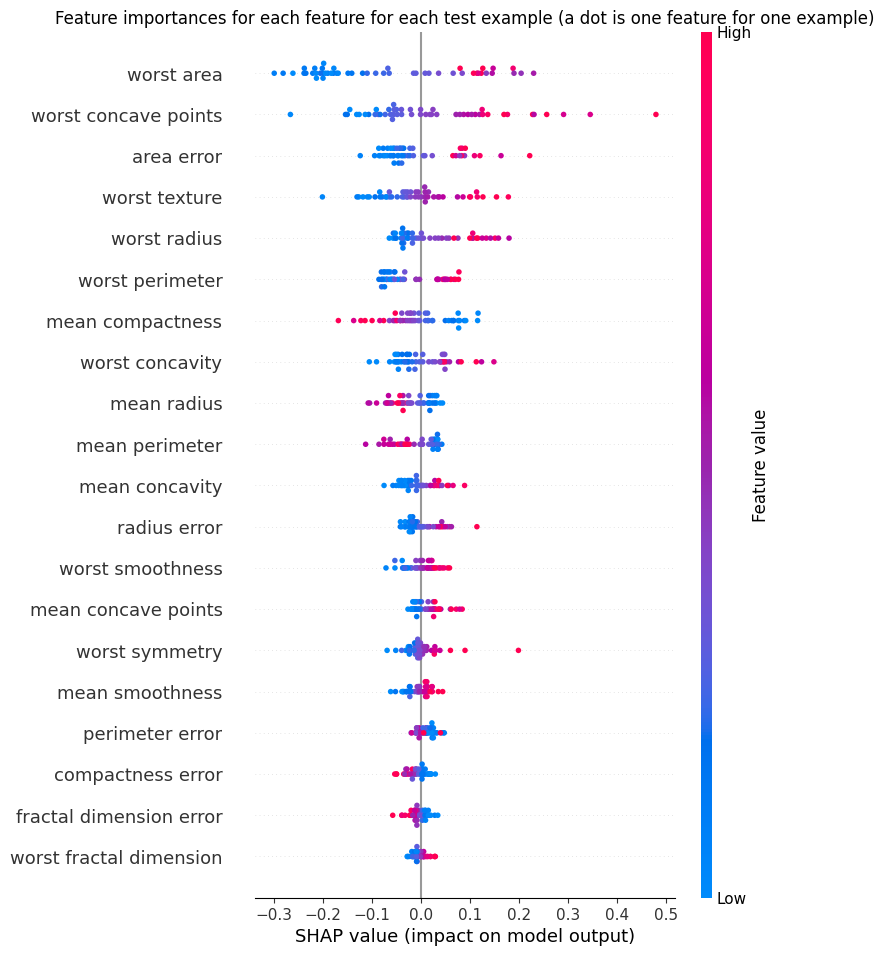

Now we analyze the strongest feature interactions of the most important feature, namely the feature "23".


In [10]:
# Load example dataset
data = datasets.load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names
n_samples = 50

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5
)

# Initialize and train model
clf = TabPFNClassifier()
clf.fit(X_train, y_train)

# Calculate SHAP values
shap_values = interpretability.shap.get_shap_values(
    estimator=clf,
    test_x=X_test[:n_samples],
    attribute_names=feature_names,
    algorithm="permutation",
)

# Create visualization
fig = interpretability.shap.plot_shap(shap_values)

## Feature Selection

Selecting the 5 most important features.

In [11]:
# Initialize model
clf = TabPFNClassifier(n_estimators=3)

# Feature selection
sfs = interpretability.feature_selection.feature_selection(
    estimator=clf,
    X=X,
    y=y,
    n_features_to_select=5,
    feature_names=feature_names
)

# Print selected features
selected_features = [feature_names[i] for i in range(len(feature_names)) if sfs.get_support()[i]]
print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")

Score with all features: 0.9806707033069401 +/- 0.00655630132909533
Score with selected features: 0.9806862288464524 +/- 0.012879405920137468
Features selected by forward sequential selection: ['mean texture', 'mean concavity', 'worst texture', 'worst area', 'worst smoothness']

Selected features:
- mean texture
- mean concavity
- worst texture
- worst area
- worst smoothness
